<a href="https://colab.research.google.com/github/guigomez36/Personal/blob/main/Experimento_Colectivo_AutoEncoder_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimento: A partir de la aplicacion de un AutoEncoder surgio como posible aplicacion usar el encoder como generador de features adicionales (Feature Engineering) para luego ingresar ese dataset "mejorado" en un modelo de arboles del tipo LightGBM (lgbm).
En este colab se prueban diferentes modelos de encoders variando las capaz intermedias (complejidad) y dimensiones obtenidas.
Como medida de performance usamos el F1 score a la salida del arbol Lgbm.
Se toman solo 10 Epochs en los modelos de CNN por razones de tiempo de computo.
El Encoder que mejor resultado da (mejor score F1) a la salida del lgbm es del tipo 152 x 64 x 152. Es decir agregamos 64 features a los 152 originales.

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DMEyF/competencia2/datasets_competencia2_2022.csv.gz", low_memory=False)


entreno el encoder con todo el dataset para agregar los features

In [ ]:

# creo clase binaria BAJA+1 y BAJA +2 vs CONTINUA
dataset["clase_binaria"] = dataset["clase_ternaria"].apply(lambda x: 0 if x=="CONTINUA" else 1) #CLASE COMBINADA

dataset=dataset.fillna(0) # RELLENO CON 0 LOS NULOS, LO NECESITA LA RED

# quito columnas que no usare en la red
drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]

X_dataset = dataset[dataset.columns.drop(drop)]
y_dataset = dataset["clase_binaria"]

# ESCALADO DE FEATURES
train_max = X_dataset.max()
train_min = X_dataset.min()

#escalo dataset para CNN
X_dataset_data = (X_dataset - train_min)/(train_max - train_min)

X_dataset_data= tf.cast(X_dataset_data, tf.float32)
#y_dataset = tf.cast(y_dataset, tf.float32)

encoder 152 x 64 x 152 (una capa)

Epoch 1/50
3177/3177 [==============================] - 11s 3ms/step - loss: 0.0157
Epoch 2/50
3177/3177 [==============================] - 8s 3ms/step - loss: 0.0063
Epoch 3/50
3177/3177 [==============================] - 8s 3ms/step - loss: 0.0059
Epoch 4/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0058
Epoch 5/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0057
Epoch 6/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0056
Epoch 7/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0056
Epoch 8/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0056
Epoch 9/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0055
Epoch 10/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0055
Epoch 11/50
3177/3177 [==============================] - 8s 2ms/step - loss: 0.0054
Epoch 12/50
3177/3177 [==============================] - 8s 3ms/step - loss: 0.0053


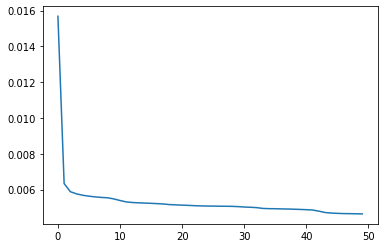

In [ ]:
from keras.layers import Input,Dense
from keras.models import Model

# number of neurons in the encoding hidden layer
encoding_dim = 64
# input placeholder
input_data = Input(shape=(152,)) # 6 is the number of features/columns
# encoder is the encoded representation of the input
encoded = Dense(encoding_dim, activation ='relu')(input_data)
# decoder is the lossy reconstruction of the input
decoded = Dense(152, activation ='sigmoid')(encoded) # 6 again number of features and should match input_data

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)
# model optimizer and loss
autoencoder = Model(input_data, decoded)

# loss function and optimizer
autoencoder.compile(optimizer='adam', loss='mae')
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train test split
#from sklearn.model_selection import train_test_split
#x_train, x_test, = train_test_split(data, test_size=0.1, random_state=42)


# train the model
history=autoencoder.fit(X_dataset_data,
                X_dataset_data,
                epochs=50,
                batch_size=256,
                shuffle=True)

autoencoder.summary()

# predict after training
# note that we take them from the *test* set
#encoded_data = encoder.predict(X_dataset_data)
plt.plot(history.history["loss"], label="Training Loss")

In [ ]:
encoded_data = encoder.predict(X_dataset_data)

25413/25413 [==============================] - 35s 1ms/step


In [ ]:
col=[]
for i in range(0,64):
  col.append('col' + str(i))
  #print (i)

In [ ]:
encoded_data1 = pd.DataFrame(encoded_data, columns=col)

In [ ]:
# convert it to tensorflow
#tensor1 = tf.convert_to_tensor(numpy_array)
#encoded_data=tf.convert_to_tensor(encoded_data)
#encoded_data = tf.cast(encoded_data, tf.float32)
res=pd.concat([dataset,encoded_data1],axis=1)

In [ ]:
res.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63
0,31115668,202101,1,0,0,56,132,1897.12,24324.75,940.32,...,0.333845,0.392765,0.093356,0.0,1.196154,0.435707,0.0,0.0,0.417855,0.0
1,31115678,202101,1,0,0,48,100,-384.72,33860.45,-515.53,...,0.305894,0.549096,0.206935,0.0,0.538877,0.638677,0.0,0.0,0.366288,0.0
2,31117415,202101,1,0,0,60,53,-3622.66,-21310.32,2442.04,...,0.186526,0.320506,0.087210,0.0,0.637762,1.129337,0.0,0.0,0.343676,0.0
3,31117711,202101,1,0,0,46,273,14542.05,125727.99,1037.77,...,0.230212,0.442883,0.229298,0.0,0.913519,0.465984,0.0,0.0,0.708296,0.0
4,31118145,202101,1,0,0,47,192,1868.27,37305.29,1496.68,...,0.229330,0.428635,0.198859,0.0,1.178028,0.682495,0.0,0.0,0.548322,0.0


In [ ]:
#entreno con enero y test en marzo luego lo aplico en mayo donde no hay informacion de clases

drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]

y_train=res["clase_binaria"][res['foto_mes']==202101]
y_test=res["clase_binaria"][res['foto_mes']==202103]
y_val=res["clase_binaria"][res['foto_mes']==202105]

X_train = res[res.columns.drop(drop)][res['foto_mes']==202101]
X_test=res[res.columns.drop(drop)][res['foto_mes']==202103]
X_val=res[res.columns.drop(drop)][res['foto_mes']==202105]



In [ ]:
#aplico lightgbm por default en python

from sklearn import datasets
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import lightgbm as ltb

In [ ]:

#lightgbm
model = ltb.LGBMClassifier()
#model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],verbose=20,eval_metric='logloss')
model.fit(X_train,y_train)


LGBMClassifier()

In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.9925
Testing accuracy 0.9872


In [ ]:
print(metrics.classification_report(y_test, model.predict(X_test)))
cm=metrics.confusion_matrix(y_test, model.predict(X_test))
print(cm)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    160921
           1       0.36      0.07      0.11      1979

    accuracy                           0.99    162900
   macro avg       0.67      0.53      0.55    162900
weighted avg       0.98      0.99      0.98    162900

[[160685    236]
 [  1846    133]]


calculo la ganancia con test desde la matriz de confusion (cm)

In [ ]:
ganancia_test=78000*133-2000*(1846)
ganancia_test

6682000

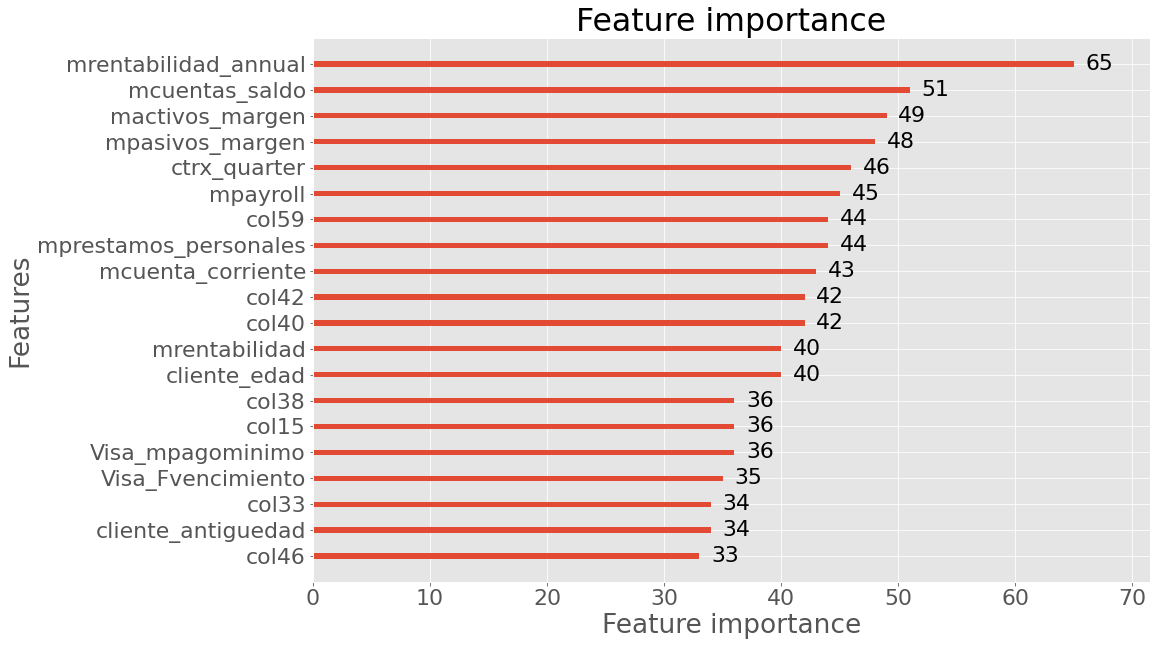

In [ ]:
plt.rcParams.update({'font.size': 22}) # must set in top
ltb.plot_importance(model, max_num_features=20,figsize=(15, 10))

aplico el modelo al dataset original (sin FE del encoder)

In [ ]:
#drop = ["clase_ternaria","numero_de_cliente"]
drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]

X_train1 = dataset[dataset.columns.drop(drop)][dataset['foto_mes']==202101]

X_test1=dataset[dataset.columns.drop(drop)][dataset['foto_mes']==202103]

y_train1=dataset["clase_binaria"][dataset['foto_mes']==202101]

y_test1=dataset["clase_binaria"][dataset['foto_mes']==202103]

In [ ]:
X_train1.head()

,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,1,0,0,56,132,1897.12,24324.75,940.32,-490.67,1306.36,...,0.0,4.0,0.0,-16247.77,0.00,3997.0,18435.59,1.0,0.0,1337.22
1,1,0,0,48,100,-384.72,33860.45,-515.53,-19.82,131.34,...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
2,1,0,0,60,53,-3622.66,-21310.32,2442.04,-5747.04,576.78,...,0.0,4.0,0.0,-33430.50,0.00,1573.0,12033.40,4.0,0.0,20011.38
3,1,0,0,46,273,14542.05,125727.99,1037.77,9338.64,2173.96,...,0.0,4.0,0.0,-9832.94,14.27,2063.0,758.21,3.0,0.0,1302.03
4,1,0,0,47,192,1868.27,37305.29,1496.68,-11.71,328.49,...,0.0,4.0,0.0,0.00,0.00,5842.0,6316.13,1.0,0.0,4680.27


In [ ]:
model1 = ltb.LGBMClassifier()
#model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],verbose=20,eval_metric='logloss')
model1.fit(X_train1,y_train1)

LGBMClassifier()

In [ ]:
print('Training accuracy {:.4f}'.format(model1.score(X_train1,y_train1)))
print('Testing accuracy {:.4f}'.format(model1.score(X_test1,y_test1)))

Training accuracy 0.9922
Testing accuracy 0.9873


In [ ]:
print(metrics.classification_report(y_test1, model1.predict(X_test1)))
cm1=metrics.confusion_matrix(y_test1, model1.predict(X_test1))
print(cm1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    160921
           1       0.38      0.06      0.11      1979

    accuracy                           0.99    162900
   macro avg       0.68      0.53      0.55    162900
weighted avg       0.98      0.99      0.98    162900

[[160711    210]
 [  1853    126]]


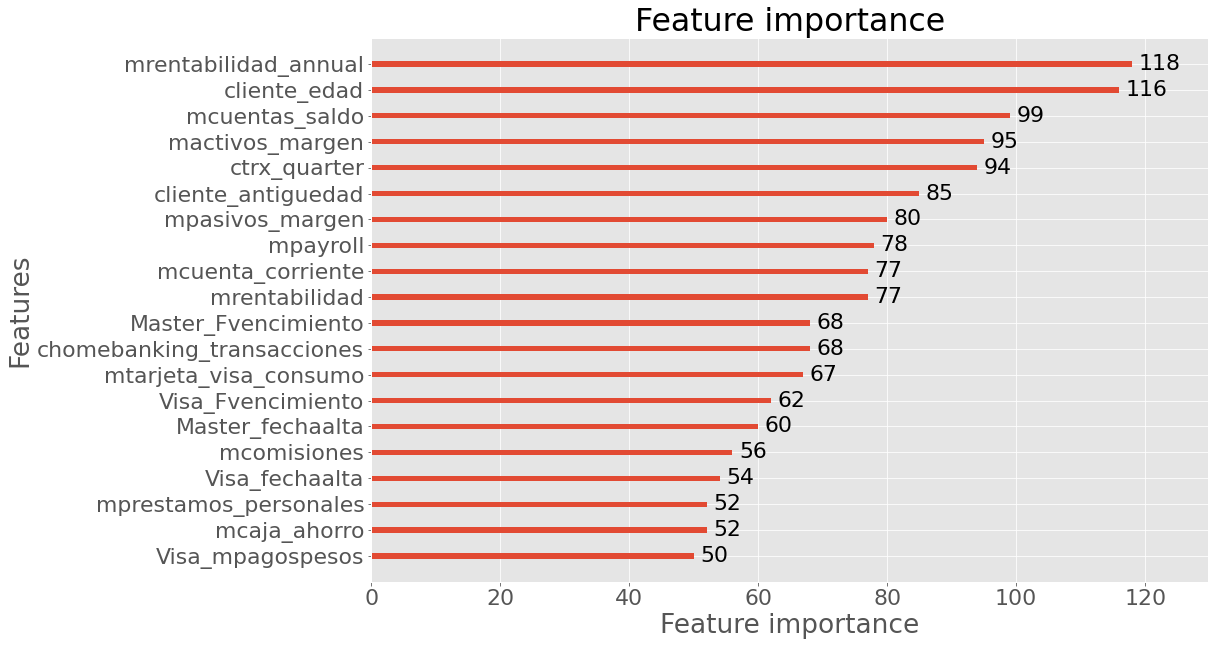

In [ ]:
plt.rcParams.update({'font.size': 22}) # must set in top
ltb.plot_importance(model1, max_num_features=20,figsize=(15, 10))

In [ ]:
ganancia_test1=78000*126-2000*(1853)
ganancia_test1

6122000

da mayor ganancia aunque es inferior  a la que manejamos normalmente (alrededor de 18M). pareciera que el mensaje es que resulta util

Experimento: existe alguna metrica que permita mejorar el desempeño del AutoEncoder propuesto?. El original usa como metrica de perdida el MAE, haremos una prueba con otras opciones.


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_labels = y_train.values.astype(bool)
test_labels = y_test.values.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(64,activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(16, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64,activation="relu"),
      layers.Dense(152, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='MeanSquaredError')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=10, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/10
313/313 [==============================] - 7s 18ms/step - loss: 0.0224 - val_loss: 0.0064
Epoch 2/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 3/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0017 - val_lo

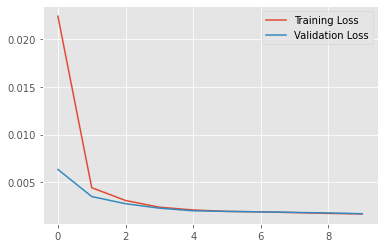

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

errores de reconstruccion normales (CONTINUA) en training

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)

In [ ]:
#
train_loss_mse = tf.keras.losses.mse(reconstructions, normal_train_data)
train_loss_mae = tf.keras.losses.mae(reconstructions, normal_train_data)
train_loss_msle = tf.keras.losses.msle(reconstructions, normal_train_data)
train_loss_mape = tf.keras.losses.mape(reconstructions, normal_train_data)


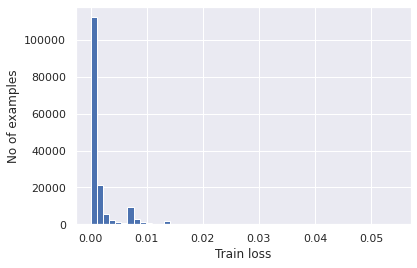

In [ ]:
plt.hist(train_loss_mse[None,:], bins=50)
#plt.hist(train_loss_mae[None, :],bins=50)
#plt.hist(train_loss_msle[None, :],bins=50)
#plt.hist(train_loss_mape[None, :],bins=50)

plt.xlabel("Train loss MSE")
plt.ylabel("No of examples")
plt.show()

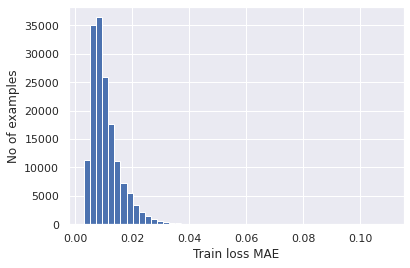

In [ ]:
#plt.hist(train_loss_mse[None,:], bins=50)
plt.hist(train_loss_mae[None, :],bins=50)
#plt.hist(train_loss_msle[None, :],bins=50)
#plt.hist(train_loss_mape[None, :],bins=50)

plt.xlabel("Train loss MAE")
plt.ylabel("No of examples")
plt.show()

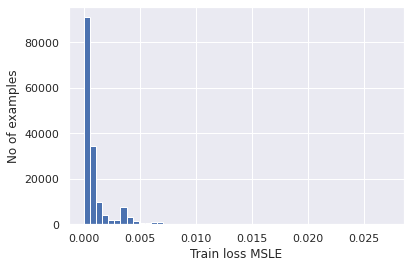

In [ ]:
#plt.hist(train_loss_mse[None,:], bins=50)
#plt.hist(train_loss_mae[None, :],bins=50)
plt.hist(train_loss_msle[None, :],bins=50)
#plt.hist(train_loss_mape[None, :],bins=50)

plt.xlabel("Train loss MSLE")
plt.ylabel("No of examples")
plt.show()

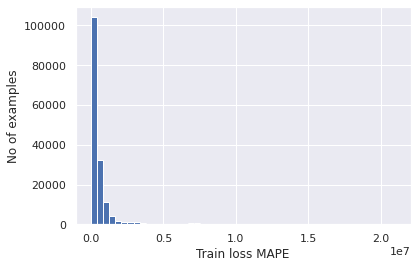

In [ ]:
#plt.hist(train_loss_mse[None,:], bins=50)
#plt.hist(train_loss_mae[None, :],bins=50)
#plt.hist(train_loss_msle[None, :],bins=50)
plt.hist(train_loss_mape[None, :],bins=50)

plt.xlabel("Train loss MAPE")
plt.ylabel("No of examples")
plt.show()

errores de reconstruccion en training anomalos

48/48 [==============================] - 0s 2ms/step


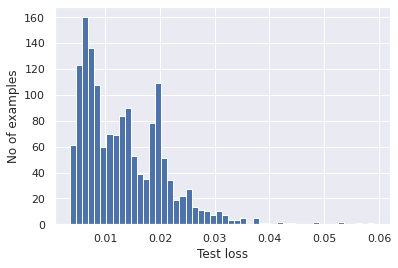

In [ ]:
reconstructions = autoencoder.predict(anomalous_train_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_train_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

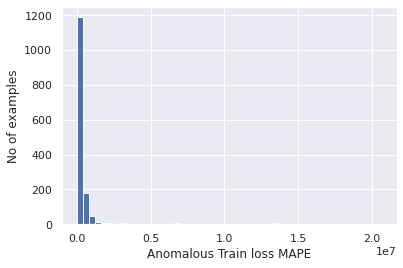

In [ ]:
anomalous_loss_mape = tf.keras.losses.mape(reconstructions, anomalous_train_data)
plt.hist(anomalous_loss_mape[None, :],bins=50)

plt.xlabel("Anomalous Train loss MAPE")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def ganancia (normal,anormal):
    gan = 78000*anormal-2000*normal
    return gan



def corte (normal,anormal):

    ganancia_max = -2000000
    threshold = None
    cantidad_envios= None

    for c in np.arange(2500000,20000000,500000):
        cant_normal = np.count_nonzero(normal > c)
        cant_anormal = np.count_nonzero( anormal > c)
        gan = ganancia (cant_normal,cant_anormal)
        if gan >ganancia_max:
            threshold = c
            ganancia_max = gan
            cantidad_envios = cant_normal+cant_anormal
    return threshold,ganancia_max,cantidad_envios

In [ ]:
anormal = anomalous_loss_mape.numpy()
normal = train_loss_mape.numpy()

c, ganancia, envios = corte(normal,anormal) # en base a entrenamiento saco mi mejor punto de corte que maximiza mi ganancia

In [ ]:
c

8500000

In [ ]:
ganancia

1842000

In [ ]:
envios

199